In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torch torchvision scikit-learn matplotlib tqdm


In [4]:
DATA_DIR = "/content/drive/MyDrive/data/"   # ← Поменяй на свой путь
NUM_CLASSES = 6
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
DEVICE = "cuda"


In [5]:
import tensorflow as tf

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [7]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],
                             [0.229,0.224,0.225]),
    ]),
}



In [8]:
image_datasets = {
    x: datasets.ImageFolder(f"{DATA_DIR}/{x}", data_transforms[x])
    for x in ["train","val","test"]
}


In [9]:
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=(x=="train"), num_workers=2)
    for x in ["train","val","test"]
}


In [10]:
class_names = image_datasets["train"].classes
class_names

['0', '1', '2', '3', '4', '5']

In [11]:
import torch.nn as nn
from torchvision import models

In [12]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 221MB/s]


In [13]:

# размораживаем все слои
for param in model.parameters():
    param.requires_grad = True

# заменяем классификатор под свои классы
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_features, NUM_CLASSES)
)

model = model.to(DEVICE)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [15]:
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import copy

In [16]:
best_f1 = 0
patience = 6
no_improve = 0
best_model_wts = None

In [18]:
EPOCHS = 7   # было больше — сократили

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    for phase in ["train", "val"]:
        model.train() if phase == "train" else model.eval()

        preds_all, labels_all = [], []
        running_loss = 0

        for x, y in dataloaders[phase]:
            x, y = x.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):
                out = model(x)
                loss = criterion(out, y)
                pred = out.argmax(1)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds_all += pred.cpu().tolist()
            labels_all += y.cpu().tolist()

        loss_epoch = running_loss / len(image_datasets[phase])
        f1_epoch = f1_score(labels_all, preds_all, average="weighted")

        print(f"{phase}: loss={loss_epoch:.4f}, F1={f1_epoch:.4f}")

        # Early stopping logic
        if phase == "val":
            if f1_epoch > best_f1:
                best_f1 = f1_epoch
                no_improve = 0
                best_model_wts = copy.deepcopy(model.state_dict())
            else:
                no_improve += 1

    scheduler.step()

    if no_improve >= patience:
        print("EARLY STOPPING!")
        break

model.load_state_dict(best_model_wts)
print("Best F1:", best_f1)



Epoch 1/7
train: loss=0.0229, F1=0.9978
val: loss=0.1641, F1=0.9331

Epoch 2/7
train: loss=0.0073, F1=0.9990
val: loss=0.1685, F1=0.9327

Epoch 3/7
train: loss=0.0033, F1=0.9998
val: loss=0.2005, F1=0.9273

Epoch 4/7
train: loss=0.0023, F1=1.0000
val: loss=0.1295, F1=0.9475

Epoch 5/7
train: loss=0.0019, F1=0.9998
val: loss=0.0638, F1=0.9764

Epoch 6/7
train: loss=0.0019, F1=0.9995
val: loss=0.0970, F1=0.9501

Epoch 7/7
train: loss=0.0013, F1=1.0000
val: loss=0.0961, F1=0.9659
Best F1: 0.9764135751018628


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize

In [20]:
model.eval()
all_preds = []
all_probs = []
all_labels = []

In [21]:
with torch.no_grad():
    for x, y in tqdm(dataloaders["test"]):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        out = model(x)
        probs = nn.Softmax(dim=1)(out).cpu().numpy()

        preds = out.argmax(1).cpu().numpy()
        labels = y.cpu().numpy()

        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels)


100%|██████████| 38/38 [08:18<00:00, 13.11s/it]


In [22]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)



In [23]:
# ROC-AUC (One vs Rest)
y_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
rocauc = roc_auc_score(y_bin, np.array(all_probs), average='weighted', multi_class='ovr')

In [24]:
acc, f1, prec, rec, rocauc, cm

(0.9841666666666666,
 0.9840904695099937,
 0.984886458570669,
 0.9841666666666666,
 np.float64(0.9999374999999999),
 array([[200,   0,   0,   0,   0,   0],
        [  0, 200,   0,   0,   0,   0],
        [  0,   0, 196,   4,   0,   0],
        [  0,   0,   0, 200,   0,   0],
        [  0,   0,   0,   0, 200,   0],
        [  0,   0,   0,   5,  10, 185]]))

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

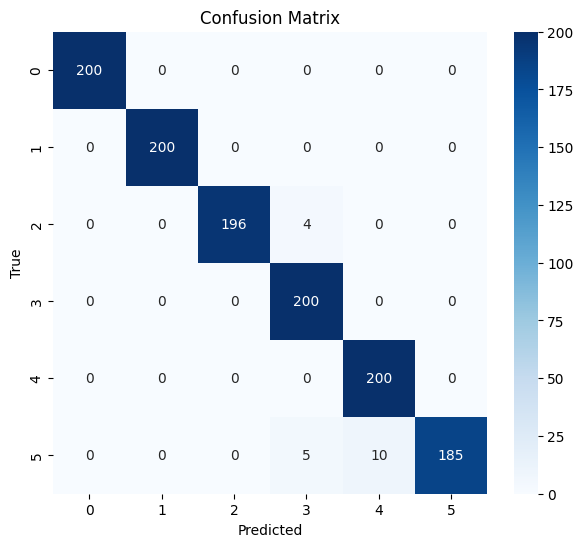

In [26]:
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

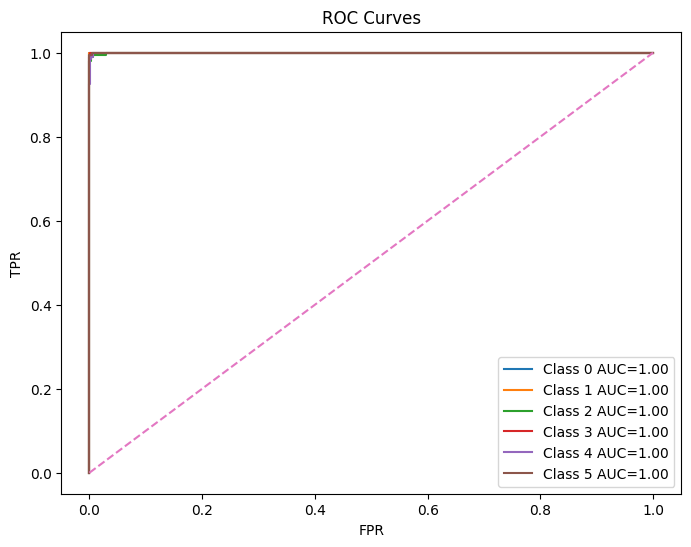

In [27]:
from sklearn.metrics import roc_curve, auc

y_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
y_score = np.array(all_probs)

plt.figure(figsize=(8,6))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} AUC={auc(fpr,tpr):.2f}")

plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.title("ROC Curves")
plt.show()

In [30]:
model.eval()

images, labels = next(iter(dataloaders["val"]))
images = images.to(DEVICE)

with torch.no_grad():
    outputs = model(images)

print("Input shape:", images.shape)
print("Output shape:", outputs.shape)
print("Forward pass OK!")


Input shape: torch.Size([32, 3, 224, 224])
Output shape: torch.Size([32, 6])
Forward pass OK!


In [32]:
import cv2
from PIL import Image
import numpy as np

def predict_image(img_path):
    model.eval()

    img = Image.open(img_path).convert("RGB")
    transform = data_transforms["test"]
    img_t = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        out = model(img_t)
        prob = nn.Softmax(dim=1)(out)
        pred = out.argmax(1).item()

    print(f"Предсказано: {pred}")
    print(f"Вероятности: {prob.cpu().numpy()}")

    plt.imshow(img)
    plt.title(f"Prediction: {pred}")
    plt.axis("off")
    plt.show()

    return pred


Предсказано: 3
Вероятности: [[2.9271736e-05 6.0389546e-05 7.5452888e-05 9.9940836e-01 2.9859020e-04
  1.2801461e-04]]


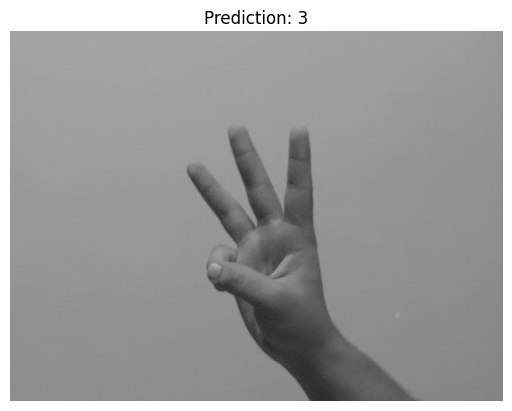

3

In [33]:
predict_image("/content/4.jpg")

Предсказано: 2
Вероятности: [[2.7597202e-05 3.8108952e-05 9.9987018e-01 3.0087094e-05 2.6811131e-05
  7.2511070e-06]]


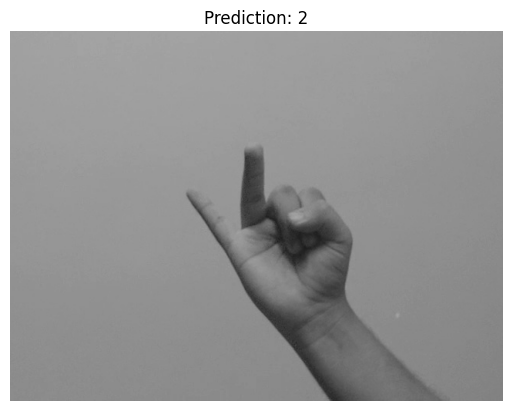

2

In [34]:
predict_image("/content/6.jpg")

Предсказано: 2
Вероятности: [[4.6827034e-05 1.2539227e-04 9.9970204e-01 7.6354401e-05 3.7975682e-05
  1.1376615e-05]]


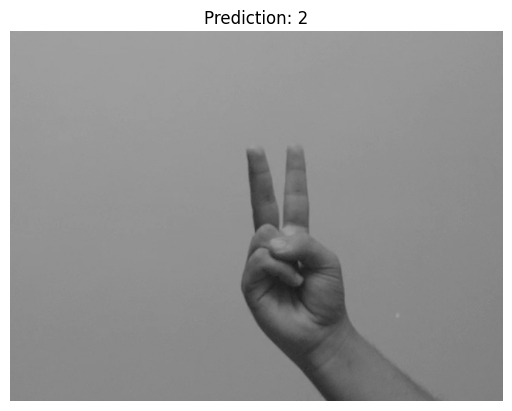

2

In [35]:
predict_image("/content/7.jpg")

In [38]:
print("accuracy:",acc)
print("f1:",f1)
print("preciion:",prec)

accuracy: 0.9841666666666666
f1: 0.9840904695099937
preciion: 0.984886458570669
